# Submitted by 
## - Ankit (ankit9@powergrid.in)
## - Shradha Dalmia (s.dalmia@powergrid.in)
## - Sahdev Singh (singhsahdev@powergrid.in)

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
# For getting data from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# For Google Colab
!unzip drive/MyDrive/AI\ ML\ Assignment/Project_data.zip

In [ ]:
# For JarvisLabs
!unzip Project_data.zip

In [3]:
import numpy as np
import os
from skimage import io
from skimage.transform import rescale
from skimage.transform import resize
from skimage.util import img_as_ubyte
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i*2 for i in range(0, 15)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,128,128,3)) # x is the number of images you use for each video,
                                    #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0] - resized_img[:,:,0].min())/(resized_img[:,:,0].max() - resized_img[:,:,0].min())
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1] - resized_img[:,:,1].min())/(resized_img[:,:,1].max() - resized_img[:,:,1].min())
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2] - resized_img[:,:,2].min())/(resized_img[:,:,2].max() - resized_img[:,:,2].min())
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batch_size = len(t) - num_batches*batch_size
        batch_data = np.zeros((rem_batch_size,15,128,128,3))
        batch_labels = np.zeros((rem_batch_size,5))
        for folder in range(0, rem_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0] - resized_img[:,:,0].min())/(resized_img[:,:,0].max() - resized_img[:,:,0].min())
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1] - resized_img[:,:,1].min())/(resized_img[:,:,1].max() - resized_img[:,:,1].min())
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2] - resized_img[:,:,2].min())/(resized_img[:,:,2].max() - resized_img[:,:,2].min())
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


### EXPERIMENT 1 STARTS -----------------------------------------------------------------

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(15, 128, 128, 3)))
model.add(Activation('relu'))
model.add(Conv3D(32, (3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, (3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.75))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(5)) # num_classes = 5
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# compile the model
optimiser = 'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#if not os.path.exists(model_name):
#    os.mkdir(model_name)
        
filepath = 'gesture_best_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1) # write the REducelronplateau code here
callbacks_list = [EarlyStopping(patience=10, verbose=1), checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot( np.argmax(results.history["val_categorical_accuracy"]), np.max(results.history["val_categorical_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

### EXPERIMENT 1 ENDS ---------------------------------------

### EXPERIMENT 2 STARTS ---------------------------------------

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(15, 128, 128, 3)))
model.add(Activation('relu'))
model.add(Conv3D(32, (3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, (3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.75))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(5)) # num_classes = 5
model.add(Activation('softmax'))

In [ ]:
# compile the model
optimiser = 'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 128, 128, 32)  2624      
                                                                 
 activation (Activation)     (None, 15, 128, 128, 32)  0         
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 126, 126, 32)  27680     
                                                                 
 activation_1 (Activation)   (None, 13, 126, 126, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 63, 63, 32)    0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 63, 63, 64)     55360     
                                                        

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#if not os.path.exists(model_name):
#    os.mkdir(model_name)
        
filepath = 'gesture_best_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1) # write the REducelronplateau code here
callbacks_list = [EarlyStopping(patience=10, verbose=1), checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1961Source path =  Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 1.60657, saving model to gesture_best_model.h5
67/67 [==============================] - 127s 2s/step - loss: 1.6094 - categorical_accuracy: 0.1961 - val_loss: 1.6066 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.6061 - categorical_accuracy: 0.2278
Epoch 2: val_loss improved from 1.60657 to 1.60386, saving model to gesture_best_model.h5
67/67 [==============================] - 117s 2s/step - loss: 1.6061 - categorical_accuracy: 0.2278 - val_loss: 1.6039 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.5963 - categorical_accuracy: 0.2293
Epoch 3: val_loss improved from 1.60386 to 1.58239, saving model to ge

### EXPERIMENT 2 ENDS ---------------------------------------

### EXPERIMENT 3 STARTS ---------------------------------------

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)] #create a list of image numbers you want to use for a particular video
    #print(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,128,128,3)) # x is the number of images you use for each video,
                                    #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2])/255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batch_size = len(t) - num_batches*batch_size
        batch_data = np.zeros((rem_batch_size,30,128,128,3))
        batch_labels = np.zeros((rem_batch_size,5))
        for folder in range(0, rem_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2])/255.0
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(30, 128, 128, 3)))
model.add(Activation('relu'))
model.add(Conv3D(32, (3, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(64, (3, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.75))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(5)) # num_classes = 5
model.add(Activation('softmax'))

2023-03-14 09:58:19.328454: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-14 09:58:19.328518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [8]:
# compile the model
optimiser = 'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 32)  2624      
                                                                 
 activation (Activation)     (None, 30, 128, 128, 32)  0         
                                                                 
 conv3d_1 (Conv3D)           (None, 28, 126, 126, 32)  27680     
                                                                 
 activation_1 (Activation)   (None, 28, 126, 126, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 28, 126, 126, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 63, 63, 32)   0         
 )                                                      

In [9]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  Project_data/train ; batch size = 10
(10, 30, 128, 128, 3)
Source path =  Project_data/val ; batch size = 10
(10, 30, 128, 128, 3)


In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#if not os.path.exists(model_name):
#    os.mkdir(model_name)
        
filepath = 'gesture_best_model-3.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1) # write the REducelronplateau code here
callbacks_list = [EarlyStopping(patience=10, verbose=1), checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 10
Epoch 1/50


2023-03-14 09:58:46.749219: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 4.6123 - categorical_accuracy: 0.2760Source path =  Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.57405, saving model to gesture_best_model-3.h5
67/67 [==============================] - 175s 3s/step - loss: 4.6123 - categorical_accuracy: 0.2760 - val_loss: 1.5741 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.5045 - categorical_accuracy: 0.3560
Epoch 00002: val_loss did not improve from 1.57405
67/67 [==============================] - 167s 3s/step - loss: 1.5045 - categorical_accuracy: 0.3560 - val_loss: 1.7491 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.4322 - categorical_accuracy: 0.4057
Epoch 00003: val_loss improved from 1.57405 to 1.48638, saving model to gesture_best_model-3.h5
67/67 [==============================] - 157s 2s/step - loss: 1.4322 -

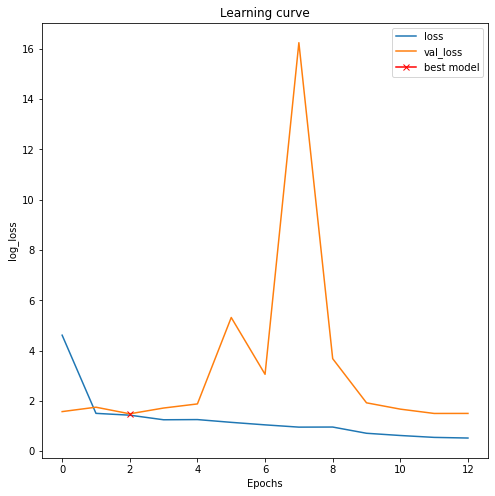

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

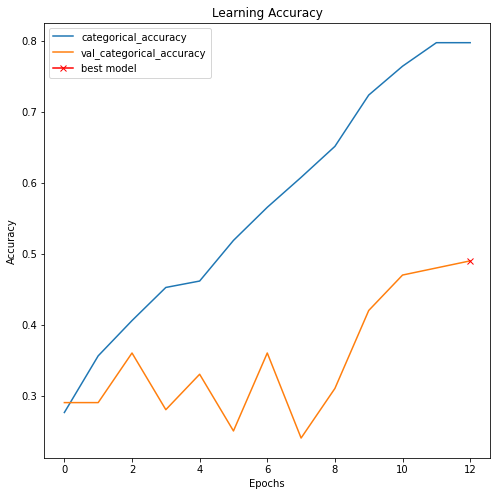

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot( np.argmax(results.history["val_categorical_accuracy"]), np.max(results.history["val_categorical_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

### EXPERIMENT 3 ENDS ---------------------------------------

### conv2d + RNN Model without drop layers Starts ---------------------------------------

In [39]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)] #create a list of image numbers you want to use for a particular video
    #print(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,128,128,3)) # x is the number of images you use for each video,
                                    #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2])/255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batch_size = len(t) - num_batches*batch_size
        batch_data = np.zeros((rem_batch_size,30,128,128,3))
        batch_labels = np.zeros((rem_batch_size,5))
        for folder in range(0, rem_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2])/255.0
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [40]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [55]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(30, 128, 128, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    LSTM(256),

    Dense(256, activation='relu'),
    
    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [56]:
# compile the model
optimiser = 'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_224 (TimeD  (None, 30, 128, 128, 32)  896      
 istributed)                                                     
                                                                 
 time_distributed_225 (TimeD  (None, 30, 128, 128, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_226 (TimeD  (None, 30, 64, 64, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_227 (TimeD  (None, 30, 64, 64, 32)   9248      
 istributed)                                                     
                                                                 
 time_distributed_228 (TimeD  (None, 30, 64, 64, 32)  

In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [58]:
filepath = 'gesture_best_model-4.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1) # write the REducelronplateau code here
callbacks_list = [EarlyStopping(patience=10, verbose=1), checkpoint, LR]

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.3086 - categorical_accuracy: 0.4646Source path =  Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.62641, saving model to gesture_best_model-4.h5
67/67 [==============================] - 160s 2s/step - loss: 1.3086 - categorical_accuracy: 0.4646 - val_loss: 1.6264 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.9015 - categorical_accuracy: 0.6621
Epoch 00002: val_loss did not improve from 1.62641
67/67 [==============================] - 157s 2s/step - loss: 0.9015 - categorical_accuracy: 0.6621 - val_loss: 1.7546 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.6693 - categorical_accuracy: 0.7572
Epoch 00003: val_loss did not improve from 1.62641
67/67 [==============================] - 154s 2s/ste

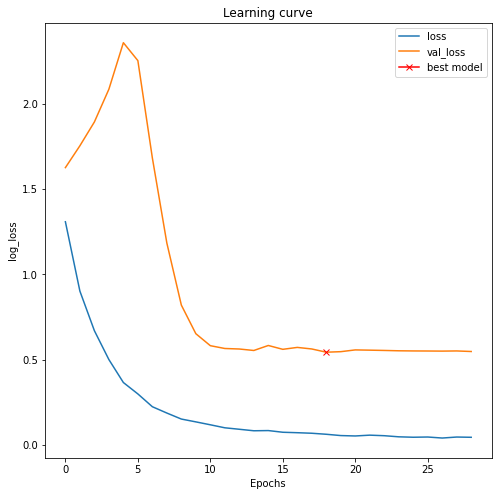

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

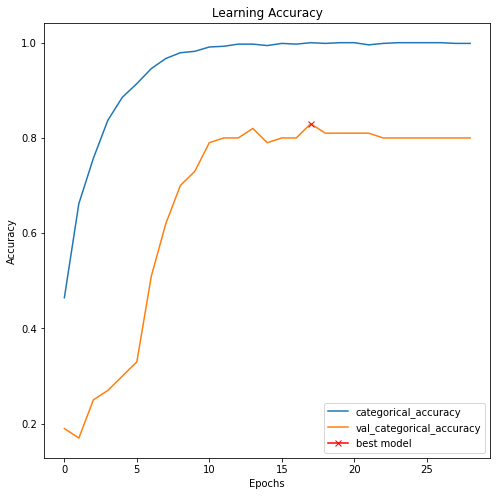

In [62]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot( np.argmax(results.history["val_categorical_accuracy"]), np.max(results.history["val_categorical_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

### conv2d + RNN Model without drop layers Ends ---------------------------------------

### conv2d + RNN Model with dropout layers Starts ---------------------------------------

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)] #create a list of image numbers you want to use for a particular video
    #print(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,128,128,3)) # x is the number of images you use for each video,
                                    #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2])/255.0
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batch_size = len(t) - num_batches*batch_size
        batch_data = np.zeros((rem_batch_size,30,128,128,3))
        batch_labels = np.zeros((rem_batch_size,5))
        for folder in range(0, rem_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image, (128, 128, 3), mode = 'constant', preserve_range = True)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_img[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (resized_img[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (resized_img[:,:,2])/255.0
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(30, 128, 128, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.25),

    Dense(256, activation='relu'),
    Dropout(0.25),
    
    Dense(5, activation='softmax')
], name="conv_2d_lstm")

2023-03-14 13:59:52.649353: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-14 13:59:52.649419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [9]:
# compile the model
optimiser = 'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 128, 128, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 128, 128, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64, 64, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64, 64, 32)  

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
filepath = 'gesture_best_model-5.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1) # write the REducelronplateau code here
callbacks_list = [EarlyStopping(patience=10, verbose=1), checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
results = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 10
Epoch 1/50


2023-03-14 13:59:57.450921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.4763 - categorical_accuracy: 0.3469Source path =  Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.74917, saving model to gesture_best_model-5.h5
67/67 [==============================] - 160s 2s/step - loss: 1.4763 - categorical_accuracy: 0.3469 - val_loss: 1.7492 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.0987 - categorical_accuracy: 0.5792
Epoch 00002: val_loss did not improve from 1.74917
67/67 [==============================] - 155s 2s/step - loss: 1.0987 - categorical_accuracy: 0.5792 - val_loss: 2.1420 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.8673 - categorical_accuracy: 0.6561
Epoch 00003: val_loss did not improve from 1.74917
67/67 [==============================] - 154s 2s/step - loss: 0.8673 - categorical_accuracy: 0.6561 - val_loss: 2.3

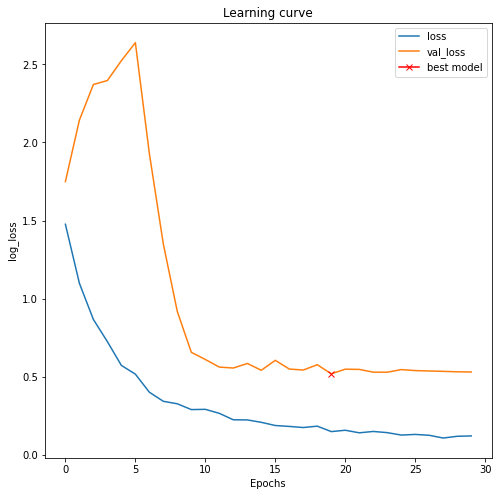

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

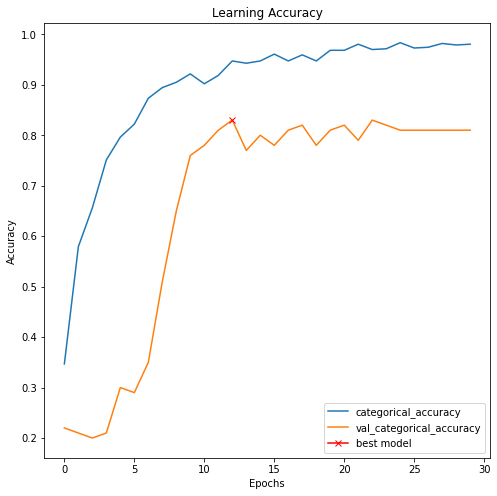

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot( np.argmax(results.history["val_categorical_accuracy"]), np.max(results.history["val_categorical_accuracy"]), \
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

### conv2d + RNN Model with dropout layers Ends ---------------------------------------